In [1]:
import numpy as np
import os, sys
import importlib
from tqdm.notebook import tqdm, trange
import pandas as pd
import json
import itertools
from IPython.display import display, HTML, clear_output

from FewShotTestHandler import FewShotTestHandler, optimize_hyperparameters, find_hyperparameters
from dataset import DatasetHandler
from similarity_metrics import Similarity
from plotting_utils import plot

ENV = os.environ["CONDA_DEFAULT_ENV"]
pd.options.display.max_rows = 200

/home/rob/vlm_benchmark/FewShotTestHandler.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
params_dict = {}

# VLM Params - vlm.____ keys are passed into VLM constructor
if ENV == "VLM_CLIP":
    from CLIP.CLIPVLM import ClipVLM as VLM
    params_dict["vlm.num_frames"] = [10]
elif ENV == "VLM_MILES":
    from MILES.wrapper import MILES_SimilarityVLM as VLM
    params_dict["vlm.num_frames"] = [4, 6, 8, 12, 16]
elif ENV == "videoclip":
    from video_clip.video_clip import VideoClipVLM as VLM
    params_dict["vlm.num_seconds"] = [4] #[2, 4, 10, 16, 32]
    params_dict["vlm.sample_strat"] = ["spread"] #["center", "start", "spread"]
elif ENV == "VLM_UNIVL":
    from UNIVL.wrapper import UniVL_SimilarityVLM as VLM
elif ENV == "VLM_VTTWINS":
    from VTTWINS.wrapper import VTTWINS_SimilarityVLM as VLM
else:
    raise NotImplementedError

# Dataset Params - dataset.____ keys are passed into DatasetHandler constructor
params_dict["dataset.name"] = ["smsm"]
params_dict["dataset.split"] = ["val"]#, "test"]
params_dict["dataset.split_type"] = ["video"]
#params_dict["dataset.class_limit"] = [5]

# Classifier Params - classifier.____ keys are passed into classifier constructor
if False:
    from classifier import WeightedTextFewShotClassifier as Classifier
    params_dict["classifier.text_weight"] = [0, 0.1, 1.0, 4.0, 10.0, 100.0]
    #params_dict["classifier.metric"] = [Similarity.COSINE, Similarity.DOT, Similarity.EUCLID]
if False:
    from classifier import HardPromptFewShotClassifier as Classifier
    params_dict["classifier.text_weight"] = [0, 0.1, 1.0, 4.0, 10.0, 100.0]
    params_dict["classifier.prompt_text"] = [
        "",
        "a video of",
        "people doing",
        "how to",
        "what is",
        "people are",
        "looks like",
        "a photo of a person doing"
    ]
if False:
    from classifier import NearestNeighborFewShotClassifier as Classifier
    params_dict["classifier.neighbor_count"] = [1, 2, 3, 4, 5, 10, 20]
    params_dict["classifier.neighbor_weights"] = ["uniform", "distance"]
if False:
    from classifier import GaussianFewShotClassifier as Classifier
    params_dict["classifier.text_weight"] = [0, 0.1, 1.0, 4.0, 10.0, 100.0]
    params_dict["classifier.prior_count"] = [0, 1, 3, 10, 30, 100]
    params_dict["classifier.prior_var"] = [0, 1, 3, 10, 30, 100]
if False:
    from classifier import SubVideoAverageFewShotClassifier as Classifier
    params_dict["classifier.text_weight"] = [0, 0.1, 1.0, 4.0, 10.0, 100.0]
    params_dict["classifier.subvideo_segment_duration"] = [1, 2, 5]
    params_dict["classifier.subvideo_max_segments"] = [32]
    params_dict["classifier.subvideo_discard_proportion"] = [0, 0.1, 0.25, 0.5]
if False:
    from classifier import TipAdapterFewShotClassifier as Classifier
    params_dict["classifier.alpha"] = [858]#[238]#[100, 120, 140] #[0.5, 1.0, 2.0]
    params_dict["classifier.beta"] = [26]#[5.07] #[2.5, 5.5, 10.0]
    params_dict["classifier.finetune_lr"] = [0]#[5.9e-4]#[1e-4, 3e-4, 1e-3, 3e-3, 1e-2]
    params_dict["classifier.finetune_epochs"] = [0]#[10] #[0, 1, 5, 10, 20]
    params_dict["classifier.weight_decay"] = [0.0001]
if False:
    from classifier.smsm_object_oracle import SmsmObjectOracleFewShotClassifier as Classifier
if False:
    from classifier.visual_prompt import VisualPromptAdditionFewShotClassifier as Classifier
    params_dict["classifier.epochs"] = [50]
    params_dict["classifier.lr"] = [1e-3] #[1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2]
    params_dict["classifier.weight_decay"] = [1] #[0.1, 1, 10]
if True:
    from classifier.visual_prompt import VisualPromptPrependFewShotClassifier as Classifier
    params_dict["classifier.prompt_token_count"] = [196]
    params_dict["classifier.epochs"] = [100]
    params_dict["classifier.warmup_epochs"] = [10]
    params_dict["classifier.lr"] = [5e-4]
    params_dict["classifier.weight_decay"] = [1e-3]
    params_dict["classifier.temperature"] = [0.05]
    params_dict["classifier.momentum"] = [0.9]
    params_dict["classifier.batch_size"] = [2]
    

# Few-Shot Test Params - test.____ keys are passed into few-shot test call
params_dict["test.n_way"] = [100]
params_dict["test.n_support"] = [0] #[0, 1, 2, 4, 8, 16, 32]#, 64]
params_dict["test.n_query"] = [None]
params_dict["test.n_episodes"] = [4]

In [3]:
test_handler = FewShotTestHandler("visual_prompt.csv")

In [4]:
vlm = None
cur_vlm_params = None
classifier = None
cur_classifier_params = None
query_dataset = None
support_dataset = None
cur_dataset_params = None

pbar = tqdm(list(itertools.product(*params_dict.values())))
for params in pbar:
    # Associate keys to each param
    params = dict(zip(params_dict.keys(), params))
    
    pbar.set_postfix(params)
    
    # vlm params
    vlm_params = {key[4:]: val for key, val in params.items() if key.startswith("vlm.")}
    classifier_params = {key[11:]: val for key, val in params.items() if key.startswith("classifier.")}
    dataset_params = {key[8:]: val for key, val in params.items() if key.startswith("dataset.")}
    test_params = {key[5:]: val for key, val in params.items() if key.startswith("test.")}
    
    # Update vlm (which forces update of classifier)
    if vlm is None or cur_vlm_params != vlm_params:
        vlm = VLM(**vlm_params)
        cur_vlm_params = vlm_params
        new_vlm = True
    else:
        new_vlm = False
            
    if new_vlm or classifier is None or cur_classifier_params != classifier_params:
        classifier = Classifier(vlm, **classifier_params)
        cur_classifier_params = classifier_params
        
    # Update dataset (and fill vlm cache for new dataset)
    if new_vlm or query_dataset is None or cur_dataset_params != dataset_params:
        query_dataset = DatasetHandler(**dataset_params)
        support_dataset_params = dict(dataset_params, split="train")
        support_dataset = DatasetHandler(**support_dataset_params)
        
        query_dataset.fill_cache(vlm)
        support_dataset.fill_cache(vlm)
        
        cur_dataset_params = dataset_params
    
    # Ensure 0-shot tests always set classifier.text_weight to 1
    if test_params["n_support"] == 0 and "text_weight" in classifier_params:
        classifier_params["text_weight"] = 1.0
    
    # Create classifier for this test (lightweight class, so no need to save over loop iterations)
    classifier = Classifier(vlm, **classifier_params)
    
    # Run test
    test_handler.run_few_shot_test(classifier, query_dataset, support_dataset, **test_params)
    
clear_output()

### Performance Plots Over Hyperparams

In [5]:
display(test_handler.results)

,vlm_class,vlm.num_frames,classifier_class,classifier.batch_size,classifier.epochs,classifier.lr,classifier.momentum,classifier.prompt_token_count,classifier.random_augment,classifier.temperature,classifier.warmup_epochs,classifier.weight_decay,query_dataset,support_dataset,n_way,n_support,n_query,n_episodes,accuracy,accuracy_std
0,MILES_SimilarityVLM,NaN,VisualPromptAdditionFewShotClassifier,NaN,50,0.0010,NaN,NaN,NaN,NaN,NaN,1.0000,smsm.v.val,smsm.v.train,100,0,NaN,4,0.032727,0.000000
1,MILES_SimilarityVLM,NaN,VisualPromptAdditionFewShotClassifier,NaN,50,0.0010,NaN,NaN,NaN,NaN,NaN,1.0000,smsm.v.val,smsm.v.train,100,1,NaN,4,0.029091,0.001113
2,MILES_SimilarityVLM,NaN,VisualPromptAdditionFewShotClassifier,NaN,50,0.0010,NaN,NaN,NaN,NaN,NaN,1.0000,smsm.v.val,smsm.v.train,100,8,NaN,4,0.028864,0.000991
3,MILES_SimilarityVLM,NaN,VisualPromptPrependFewShotClassifier,NaN,50,0.0010,NaN,196.0,NaN,NaN,10.0,0.0010,smsm.v.val,smsm.v.train,100,0,NaN,4,0.032727,0.000000
4,MILES_SimilarityVLM,NaN,VisualPromptPrependFewShotClassifier,NaN,50,0.0010,NaN,196.0,NaN,NaN,10.0,0.0010,smsm.v.val,smsm.v.train,100,1,NaN,4,0.026364,0.001928
5,MILES_SimilarityVLM,NaN,VisualPromptPrependFewShotClassifier,NaN,20,0.1000,NaN,196.0,NaN,0.05,5.0,0.0001,smsm.v.val,smsm.v.train,100,0,NaN,4,0.032727,0.000000
6,MILES_SimilarityVLM,NaN,VisualPromptPrependFewShotClassifier,NaN,20,0.1000,NaN,196.0,NaN,0.05,5.0,0.0001,smsm.v.val,smsm.v.train,100,1,NaN,4,0.025909,0.002611
7,MILES_SimilarityVLM,NaN,VisualPromptPrependFewShotClassifier,NaN,20,0.0010,NaN,196.0,NaN,0.05,5.0,0.0001,smsm.v.val,smsm.v.train,100,0,NaN,4,0.032727,0.000000
8,MILES_SimilarityVLM,NaN,VisualPromptPrependFewShotClassifier,NaN,20,0.0010,NaN,196.0,NaN,0.05,5.0,0.0001,smsm.v.val,smsm.v.train,100,1,NaN,4,0.034773,0.001746
9,MILES_SimilarityVLM,NaN,VisualPromptPrependFewShotClassifier,NaN,20,0.0100,NaN,196.0,NaN,0.05,5.0,0.0001,smsm.v.val,smsm.v.train,100,0,NaN,4,0.032727,0.000000


7 Overall Lines
2 Separate Plots


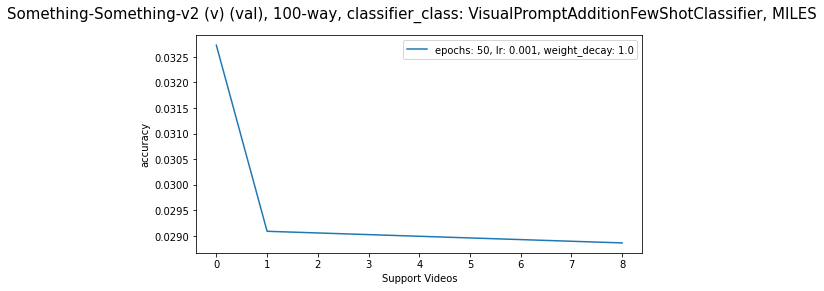

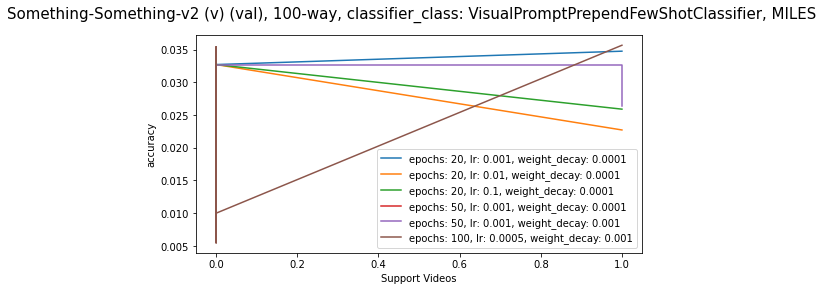

In [6]:
plot(
    test_handler.results,
    x_col="n_support",
    y_col="accuracy",
    plot_descriptor_cols=["query_dataset", "n_way", "classifier_class", "vlm_class"],
    line_descriptor_cols=["classifier.epochs", "classifier.lr", "classifier.weight_decay"]
)

### Hyperparameter Search

In [7]:
# Show best hyperparameters directly
display(find_hyperparameters(
    test_handler.results,
    hyperparam_cols=["classifier.text_weight", "classifier.alpha", "classifier.beta", "classifier.finetune_epochs", "classifier.finetune_lr", "classifier.weight_decay"],
    average_over_cols=["n_way", "n_support"]
))

,vlm_class,vlm.num_frames,classifier_class,classifier.batch_size,classifier.epochs,classifier.lr,classifier.momentum,classifier.prompt_token_count,classifier.random_augment,classifier.temperature,classifier.warmup_epochs,query_dataset,support_dataset,n_query,n_episodes,classifier.weight_decay
1,MILES_SimilarityVLM,4.0,VisualPromptPrependFewShotClassifier,8.0,100,0.0005,0.9,196.0,True,0.05,10.0,smsm.v.val,smsm.v.train,NaN,4,0.0010
0,MILES_SimilarityVLM,4.0,VisualPromptPrependFewShotClassifier,2.0,100,0.0005,0.9,196.0,True,0.05,10.0,smsm.v.val,smsm.v.train,NaN,4,0.0010
2,MILES_SimilarityVLM,4.0,VisualPromptPrependFewShotClassifier,NaN,100,0.0005,0.9,196.0,True,0.05,10.0,smsm.v.val,smsm.v.train,NaN,4,0.0010
8,MILES_SimilarityVLM,NaN,VisualPromptPrependFewShotClassifier,NaN,20,0.0010,NaN,196.0,NaN,0.05,5.0,smsm.v.val,smsm.v.train,NaN,4,0.0001
11,MILES_SimilarityVLM,NaN,VisualPromptPrependFewShotClassifier,NaN,50,0.0010,0.5,196.0,NaN,0.05,10.0,smsm.v.val,smsm.v.train,NaN,4,0.0010
12,MILES_SimilarityVLM,NaN,VisualPromptPrependFewShotClassifier,NaN,50,0.0010,0.9,196.0,NaN,0.05,10.0,smsm.v.val,smsm.v.train,NaN,4,0.0001
7,MILES_SimilarityVLM,NaN,VisualPromptAdditionFewShotClassifier,NaN,50,0.0010,NaN,NaN,NaN,NaN,NaN,smsm.v.val,smsm.v.train,NaN,4,1.0000
14,MILES_SimilarityVLM,NaN,VisualPromptPrependFewShotClassifier,NaN,50,0.0010,NaN,196.0,NaN,NaN,10.0,smsm.v.val,smsm.v.train,NaN,4,0.0010
10,MILES_SimilarityVLM,NaN,VisualPromptPrependFewShotClassifier,NaN,20,0.1000,NaN,196.0,NaN,0.05,5.0,smsm.v.val,smsm.v.train,NaN,4,0.0001
9,MILES_SimilarityVLM,NaN,VisualPromptPrependFewShotClassifier,NaN,20,0.0100,NaN,196.0,NaN,0.05,5.0,smsm.v.val,smsm.v.train,NaN,4,0.0001


In [8]:
optimized_results = optimize_hyperparameters(
    test_handler.results,
    hyperparam_cols=["classifier.text_weight", "classifier.alpha", "classifier.beta", "classifier.finetune_epochs", "classifier.finetune_lr", "classifier.weight_decay"],
    average_over_cols=["n_way", "n_support"]
)
display(optimized_results)

,vlm_class,vlm.num_frames,classifier_class,classifier.batch_size,classifier.epochs,classifier.lr,classifier.momentum,classifier.prompt_token_count,classifier.random_augment,classifier.temperature,classifier.warmup_epochs,classifier.weight_decay,query_dataset,support_dataset,n_way,n_support,n_query,n_episodes,accuracy,accuracy_std


### Plot Results

In [9]:
plot(
    optimized_results,
    x_col="n_support",
    y_col="accuracy",
    plot_descriptor_cols=["query_dataset", "n_way", "classifier_class"],
    line_descriptor_cols=["vlm_class"]
)

0 Overall Lines


In [10]:
plot(
    optimized_results,
    x_col="n_support",
    y_col="accuracy",
    plot_descriptor_cols=["query_dataset", "n_way", "vlm_class"],
    line_descriptor_cols=["classifier_class"]
)

0 Overall Lines


### Show Validation Plots Over Hyperparameters

In [11]:
plot(
    optimize_hyperparameters(
        test_handler.results,
        hyperparam_cols=["classifier.alpha", "classifier.beta"],
        average_over_cols=["n_way", "n_support"],
        val_split="val",
        test_split="val"
    ),
    x_col="n_support",
    y_col="accuracy",
    plot_descriptor_cols=["query_dataset", "n_way", "classifier_class", "vlm_class"],
    line_descriptor_cols=["classifier.finetune_epochs"]
)

KeyError: 'classifier.finetune_epochs'

In [ ]:
plot(
    optimize_hyperparameters(
        test_handler.results,
        hyperparam_cols=["classifier.beta", "classifier.finetune_epochs", "classifier.finetune_lr"],
        average_over_cols=["n_way", "n_support"],
        val_split="val",
        test_split="val"
    ),
    x_col="n_support",
    y_col="accuracy",
    plot_descriptor_cols=["query_dataset", "n_way", "classifier_class", "vlm_class"],
    line_descriptor_cols=["classifier.alpha"]
)

In [ ]:
plot(
    optimize_hyperparameters(
        test_handler.results,
        hyperparam_cols=["classifier.alpha", "classifier.finetune_epochs", "classifier.finetune_lr"],
        average_over_cols=["n_way", "n_support"],
        val_split="val",
        test_split="val"
    ),
    x_col="n_support",
    y_col="accuracy",
    plot_descriptor_cols=["query_dataset", "n_way", "classifier_class", "vlm_class"],
    line_descriptor_cols=["classifier.beta"]
)